In [ ]:
!pip install pyspark

!pip3 install spacy

!spacy download en_core_web_lg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=4fee7bd73597241b77e965fd5ab1d1231d84b7825d89f23427fb1b42966b181b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from pyspark.sql import SparkSession
import re
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import spacy


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("FakeNewsAnalysis").getOrCreate()

# Load the parquet file
df = spark.read.parquet("/content/drive/MyDrive/Base_news_corregido")

df.show()
# Convert to RDD
rdd = df.select("title", "text", "label").rdd

+--------------------+--------------------+-----+
|               title|                text|label|
+--------------------+--------------------+-----+
|NAZI Flying Sauce...|. NAZI Flying Sau...|    1|
|Mitt Romney Calls...|The most recent R...|    0|
|Clinton takes the...|PHILADELPHIA — Ch...|    0|
|The Deteriorating...|Tweet Widget by Y...|    1|
|Old rivals Obama ...|Washington (CNN) ...|    0|
|George Soros begi...|Share on Facebook...|    1|
|Donald Trump is d...|Last year, during...|    0|
|How To Open Your ...|Did you know? The...|    1|
|VA Secretary Robe...|Veterans Affairs ...|    0|
|Three Likely GOP ...|Three possible Re...|    0|
|Ryan Endorses Tru...|After his shotgun...|    0|
|Podesta WikiLeaks...|Here is a review ...|    1|
|3 Year Old Son of...|You Are Here: Hom...|    1|
|The inane spectac...|What happened was...|    0|
|Clinton “Fixer”: ...|Email \nClinton w...|    1|
|Slain reporter's ...|(CNN) One day aft...|    0|
|Hillary Clinton’s...|It’s not really i...|    0|


In [ ]:
# Helper functions
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

en = spacy.load("en_core_web_lg")
stop_words = en.Defaults.stop_words
stop_words.add("s")
stop_words.add("t")
stop_words.add("i")
stop_words.add("u")
# print(set(list(stopwords)))
# stop_words = set(["the", "is", "in", "and", "to", "a", "of", "for"
#                   , "on", "with", "as", "by", "an", "be", "this"
#                   , "that", "it", "at", "from", "or", "which"
#                   , "you", "but", "not", "s", "u", "i", "t"])

def remove_stop_words(words):
    return [word for word in words if word not in stop_words]

# Map step for titles and texts separately, considering NULL values
def map_words(row):
    label = row['label']
    title_words = []
    text_words = []

    if row['title'] is not None:
        title_words = remove_stop_words(tokenize(row['title']))
    if row['text'] is not None:
        text_words = remove_stop_words(tokenize(row['text']))

    title_word_pairs = [((label, 'title', word), 1) for word in title_words]
    text_word_pairs = [((label, 'text', word), 1) for word in text_words]

    return title_word_pairs + text_word_pairs


In [ ]:
mapped_rdd = rdd.flatMap(map_words)

# Reduce step
reduced_rdd = mapped_rdd.reduceByKey(lambda x, y: x + y)

# Calculate word probabilities
word_counts = reduced_rdd.map(lambda x: (x[0][0], (x[0][2], x[1]))) \
    .groupByKey() \
    .mapValues(lambda counts: dict(counts)) \
    .collectAsMap()

total_fake_words = sum(word_counts[1].values())
total_real_words = sum(word_counts[0].values())

P_word_given_fake = {word: (count / total_fake_words) for word, count in word_counts[1].items()}
P_word_given_real = {word: (count / total_real_words) for word, count in word_counts[0].items()}

# Calculate prior probabilities
total_articles = rdd.count()
fake_articles = rdd.filter(lambda row: row['label'] == 1).count()
real_articles = total_articles - fake_articles

P_fake = fake_articles / total_articles
P_real = real_articles / total_articles

In [ ]:
# Function to calculate log probabilities of a new article being fake or real
def predict_article(title, text):
    title_words = remove_stop_words(tokenize(title)) if title is not None else []
    text_words = remove_stop_words(tokenize(text)) if text is not None else []
    words = title_words + text_words

    log_prob_fake = math.log(P_fake)
    log_prob_real = math.log(P_real)

    for word in words:
        log_prob_fake += math.log(P_word_given_fake.get(word, 1 / (total_fake_words + len(P_word_given_fake))))
        log_prob_real += math.log(P_word_given_real.get(word, 1 / (total_real_words + len(P_word_given_real))))

    if log_prob_fake > log_prob_real:
        return "Fake"
    else:
        return "Real"

# Test with a sample article
sample_title = "Sample news title"
sample_text = "Sample news text content"
prediction = predict_article(sample_title, sample_text)
print(f"The article is predicted to be: {prediction}")

The article is predicted to be: Real


In [ ]:
# Swap keys and values to prepare for sorting
swapped_rdd = reduced_rdd.map(lambda x: (x[1], x[0]))

# Filter and sort by count for each category
fake_title_words = swapped_rdd.filter(lambda x: x[1][0] == 1 and x[1][1] == 'title').sortByKey(False)
fake_text_words = swapped_rdd.filter(lambda x: x[1][0] == 1 and x[1][1] == 'text').sortByKey(False)
real_title_words = swapped_rdd.filter(lambda x: x[1][0] == 0 and x[1][1] == 'title').sortByKey(False)
real_text_words = swapped_rdd.filter(lambda x: x[1][0] == 0 and x[1][1] == 'text').sortByKey(False)

# Get top N words
top_n = 20
top_fake_title_words = fake_title_words.take(top_n)
top_fake_text_words = fake_text_words.take(top_n)
top_real_title_words = real_title_words.take(top_n)
top_real_text_words = real_text_words.take(top_n)




In [ ]:
# Function to create bar plot
def plot_top_words(top_words, title):
    words = [word for count, (label, category, word) in top_words]
    counts = [count for count, (label, category, word) in top_words]
    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='blue')
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()
    # plt.savefig(title)


Top words in fake news titles:


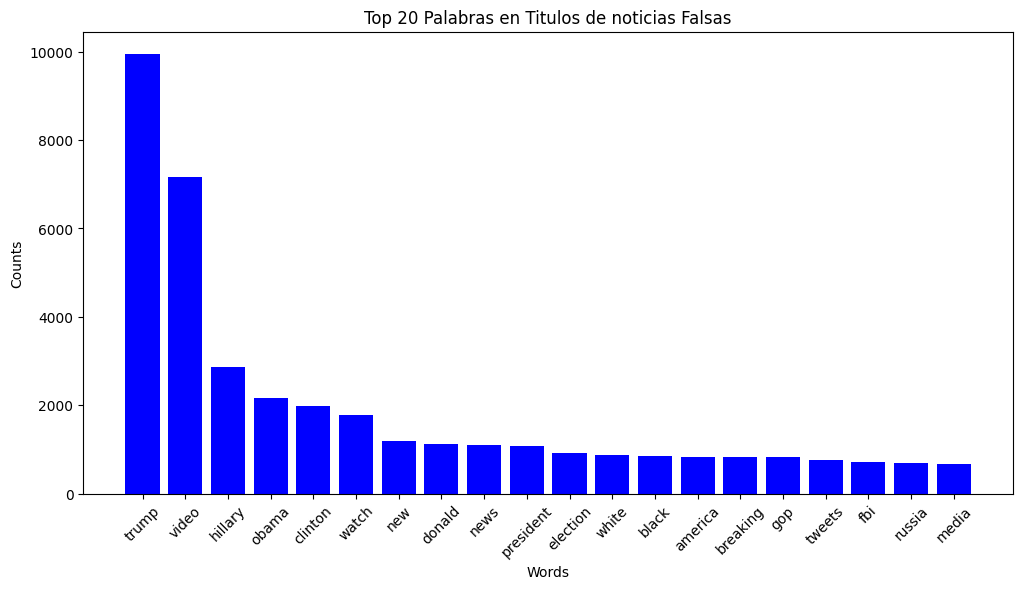

Top words in fake news texts:


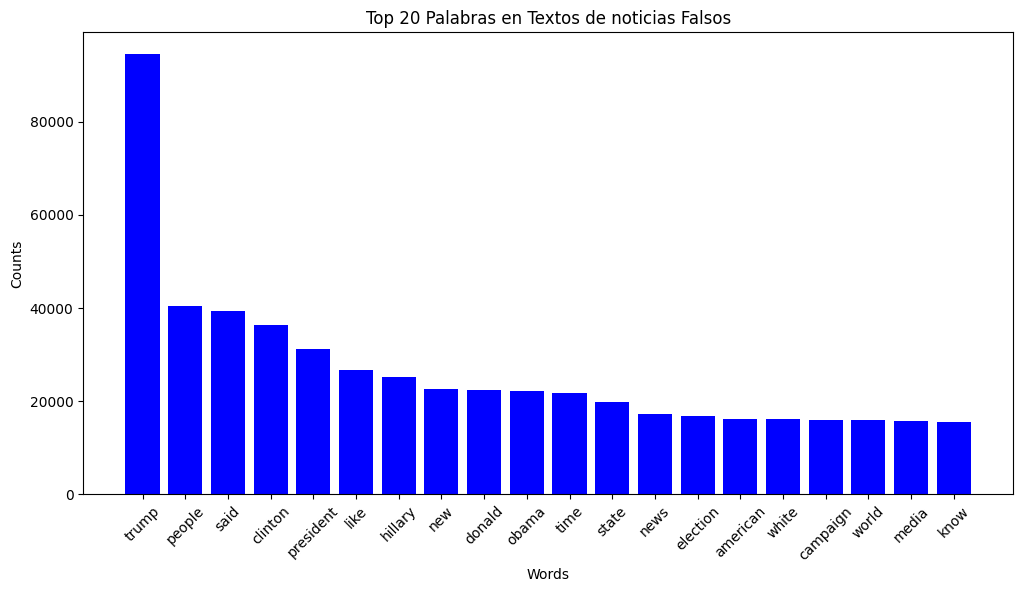

Top words in real news titles:


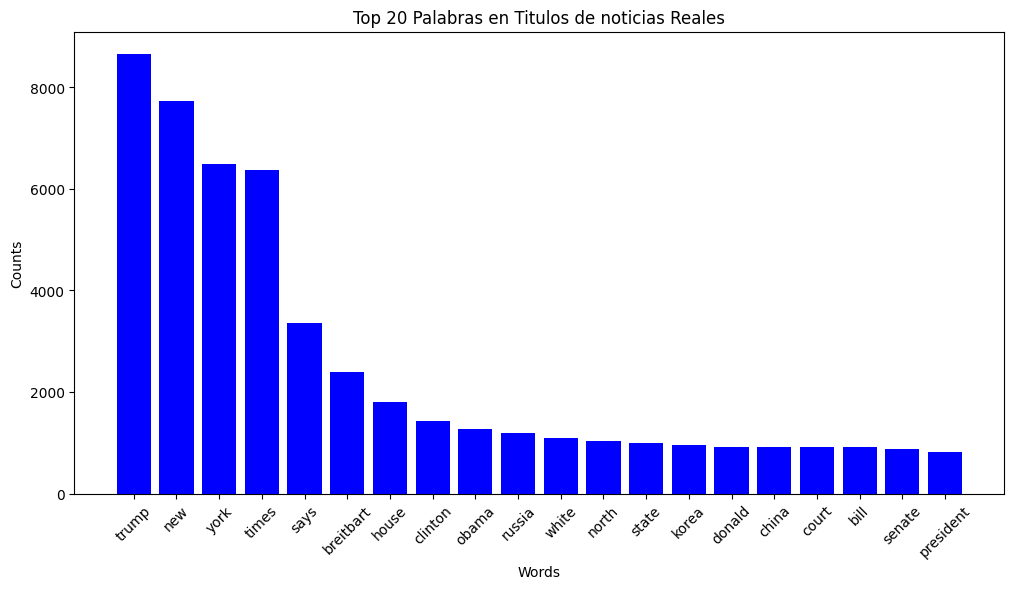

Top words in real news texts:


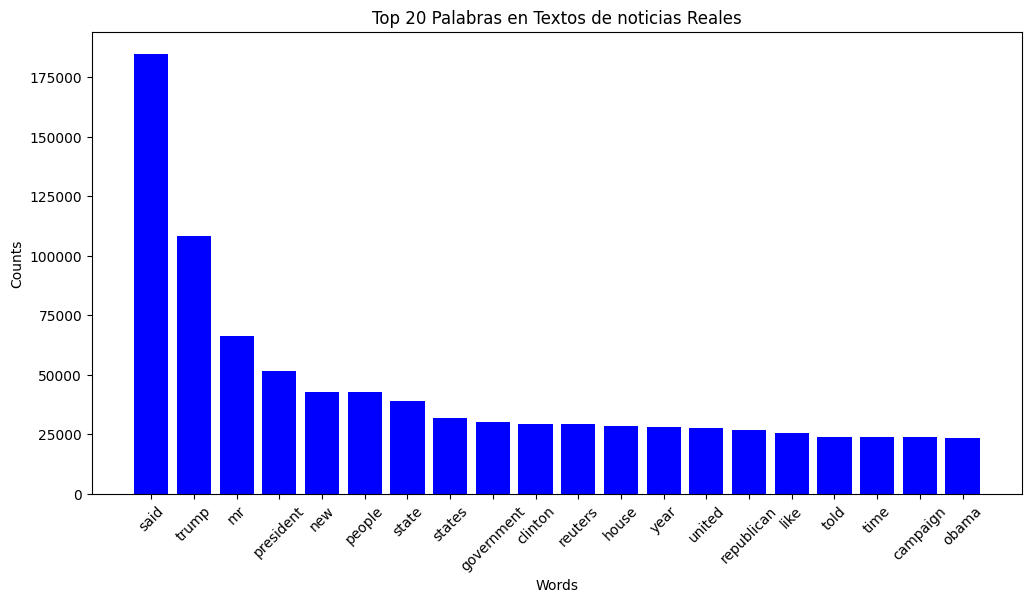

In [ ]:
# Plotting
print("Top words in fake news titles:")
plot_top_words(top_fake_title_words, "Top 20 Palabras en Titulos de noticias Falsas")

print("Top words in fake news texts:")
plot_top_words(top_fake_text_words, "Top 20 Palabras en Textos de noticias Falsos")

print("Top words in real news titles:")
plot_top_words(top_real_title_words, "Top 20 Palabras en Titulos de noticias Reales")

print("Top words in real news texts:")
plot_top_words(top_real_text_words, "Top 20 Palabras en Textos de noticias Reales")